In [1]:
import os
import math
import re
import json

import random

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer

# from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

c:\users\yasht\fakenews\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
%matplotlib inline
random.seed(1)
np.random.seed(1)

In [3]:
w2v_model_file = 'imdb_review_w2v.model' # change each time
d2vdm_model_file = 'imdb_review_d2vdm.model' # change each time
d2vdbow_model_file = 'imdb_review_d2vdbow.model' # change each time
train_csv = 'train_df.csv'
test_csv = 'test_df.csv'
df_csv = 'df.csv'
df_pkl = 'df.pkl'

neg_bound = 4
pos_bound = 7

train_size = 0.80

num_reviews = 10000
doc_ids = np.asarray(range(num_reviews))

min_occ = 5 # The minimum number of occurrences for a word to be considered

In [4]:
def my_train_test_split(*args):
    return train_test_split(*args, train_size=train_size, random_state=1)

In [5]:
def get_w2v_vector(word):
    """Get the vector for a word"""
    try:
        return model.wv[word]
    except:
        print(word)
        raise
        
def filter_tokens(tokens, vocab=None):
    if vocab is None:
        vocab = w2v_vocab
    return [token for token in tokens if token in vocab]

In [6]:
en_stop = set(nltk.corpus.stopwords.words('english'))
stemmer = WordNetLemmatizer()

def tokenize(text):
    text = text.lower()
    # Remove non-word characters
    text = re.sub(r'[^a-z]', ' ', text)
    # Remove single letters
    text = re.sub(r'\b[a-z]{0,3}\b', ' ', text)
    # Merge multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Lemmatization
    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    
    return tokens

# Run once

In [7]:
half_reviews = num_reviews // 2
assert half_reviews == num_reviews / 2

def load_train_or_test(dir):
    random.seed(3)
    """
    Return the negative and positive train or test data
    """
    def load_neg_or_pos(sub, is_pos):
        res = []
        for file_name in os.listdir(sub):
            with open(sub + file_name, encoding='utf8') as file:
                underscore_ind = file_name.index('_')
                period_ind = file_name.index('.')
                id = int(file_name[:underscore_ind])
                rating = int(file_name[underscore_ind + 1:period_ind])
                text = next(file)
                res.append([rating, text])
        return res
    # Only choose more polar ratings
    neg = [[rating, text] for rating, text in load_neg_or_pos(dir + '/neg/', False) if rating <= neg_bound]
    pos = [[rating, text] for rating, text in load_neg_or_pos(dir + '/pos/', True) if rating >= pos_bound]
    random.shuffle(neg)
    random.shuffle(pos)
    both = neg[:half_reviews] + pos[:half_reviews]
    random.shuffle(both)
    return pd.DataFrame(both, columns=['Rating', 'Text'])

In [8]:
df = load_train_or_test('./train') #.append(load_train_or_test('./test'))

In [9]:
df

Rating                                               Text
0         10  this may not be War & Peace, but the two Acade...
1         10  after seeing this film for the 3rd time now i ...
2          1  When 'My Deja Vu, My Deja Vu' aired last seaso...
3         10  "Magic" isn't too strong a word for the spell ...
4         10  You could stage a version of Charles Dickens' ...
...      ...                                                ...
9995       8  Judy Davis shows us here why she is one of Aus...
9996       2  Don't get me wrong, I love action and revenge ...
9997       8  Im a huge M Lillard fan that's why I ended up ...
9998       8  In Iran women are prohibited from attending li...
9999       4  The movie had a cute opening, I truly believed...

[10000 rows x 2 columns]

In [10]:
df['Tokens'] = df['Text'].apply(tokenize)
# Clean up the text too
df['Text'] = df['Tokens'].apply(" ".join)

In [11]:
df

Rating                                               Text  \
0         10  peace academy noms forthcoming genius james wo...   
1         10  seeing film time think almost adam worst film ...   
2          1  deja deja aired last season pleased scrub thou...   
3         10  magic strong word spell film weave find relaxi...   
4         10  could stage version charles dickens christmas ...   
...      ...                                                ...   
9995       8  judy davis show australia respected loved acto...   
9996       2  wrong love action revenge flick seen many sinc...   
9997       8  huge lillard ended watching movie honestly dou...   
9998       8  iran woman prohibited attending live sporting ...   
9999       4  movie cute opening truly believed best romanti...   

                                                 Tokens  
0     [peace, academy, noms, forthcoming, genius, ja...  
1     [seeing, film, time, think, almost, adam, wors...  
2     [deja, deja, aired, last, season, pleased, scr...  
3     [magic, strong, word, spell, film, weave, find...  
4     [could, stage, version, charles, dickens, chri...  
...                                                 ...  
9995  [judy, davis, show, australia, respected, love...  
9996  [wrong, love, action, revenge, flick, seen, ma...  
9997  [huge, lillard, ended, watching, movie, honest...  
9998  [iran, woman, prohibited, attending, live, spo...  
9999  [movie, cute, opening, truly, believed, best, ...  

[10000 rows x 3 columns]

In [12]:
# Save processed data
# df.to_csv(df_csv)
df.to_pickle(df_pkl)

In [181]:
# # Train and save model
# model = Word2Vec(sentences=train_df['Tokens'])
# model.save(w2v_model_file)

In [182]:
# w2v_vocab = set(model.wv.key_to_index.keys())
# w2v_vocab_ord = np.array(list(model.wv.key_to_index.keys()))

In [183]:
# # Keep only tokens that showed up the required number of times
# train_df['Tokens'] = train_df['Tokens'].apply(filter_tokens)

# test_df['Tokens'] = test_df['Text'].apply(lambda text: filter_tokens(tokenize(text)))
# # Process test text too
# test_df['Text'] = test_df['Tokens'].apply(" ".join)

In [184]:
# # The vectors corresponding to each reviews' words
# df['Vectors'] = df['Tokens'].apply(get_vector)

In [9]:
# Train Doc2Vec model
import collections
from gensim.models.callbacks import CallbackAny2Vec

tagged_docs = [TaggedDocument(words=df['Tokens'][doc_id], tags=[doc_id]) for doc_id in doc_ids]
assert type(tagged_docs[0].words) == list
# print(len(tagged_docs), type(tagged_docs[0].words), tagged_docs[0])
X_train_docs, X_test_docs = my_train_test_split(tagged_docs)

class PrintLoss(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    
    def on_epoch_begin(self, model):
        model.running_training_loss = 0.0
        print(f'Starting epoch {self.epoch}', end=' | ')
    
    def on_epoch_end(self, model):
        print(f'Finished epoch {self.epoch}, loss = {model.get_latest_training_loss()}')
        self.epoch += 1

def train_d2v(model):
    model.random.seed(1)
    model.build_vocab(X_train_docs)
    model.train(X_train_docs, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True, callbacks=[PrintLoss()])
    return model

In [ ]:
d2vdm_model = train_d2v(Doc2Vec(dm=1, vector_size=50, min_count=min_occ, epochs=100, seed=1))
d2vdm_model.save(d2vdm_model_file)
print('Trained d2vdm')

d2vdbow_model = train_d2v(Doc2Vec(dm=0, vector_size=50, min_count=min_occ, epochs=100, seed=1))
d2vdbow_model.save(d2vdbow_model_file)
print('Trained d2vdbow')

In [10]:
d2vdm100_model = train_d2v(Doc2Vec(dm=1, vector_size=100, min_count=min_occ, epochs=100, seed=1))
d2vdm100_model.save('d2vdm100.model')
print('Trained d2vdm')

d2vdbow100_model = train_d2v(Doc2Vec(dm=0, vector_size=100, min_count=min_occ, epochs=100, seed=1))
d2vdbow100_model.save('d2vdbow100.model')
print('Trained d2vdbow')

Starting epoch 0 | Finished epoch 0, loss = 0.0
Starting epoch 1 | Finished epoch 1, loss = 0.0
Starting epoch 2 | Finished epoch 2, loss = 0.0
Starting epoch 3 | Finished epoch 3, loss = 0.0
Starting epoch 4 | Finished epoch 4, loss = 0.0
Starting epoch 5 | Finished epoch 5, loss = 0.0
Starting epoch 6 | Finished epoch 6, loss = 0.0
Starting epoch 7 | Finished epoch 7, loss = 0.0
Starting epoch 8 | Finished epoch 8, loss = 0.0
Starting epoch 9 | Finished epoch 9, loss = 0.0
Starting epoch 10 | Finished epoch 10, loss = 0.0
Starting epoch 11 | Finished epoch 11, loss = 0.0
Starting epoch 12 | Finished epoch 12, loss = 0.0
Starting epoch 13 | Finished epoch 13, loss = 0.0
Starting epoch 14 | Finished epoch 14, loss = 0.0
Starting epoch 15 | Finished epoch 15, loss = 0.0
Starting epoch 16 | Finished epoch 16, loss = 0.0
Starting epoch 17 | Finished epoch 17, loss = 0.0
Starting epoch 18 | Finished epoch 18, loss = 0.0
Starting epoch 19 | Finished epoch 19, loss = 0.0
Starting epoch 20 | 

NameError: name 'd2vdbo100w_model' is not defined

In [22]:
def get_d2v_sim(model, doc1, doc2):
    """Get cos similarity of 2 docs' vectors"""
    vector1 = model.infer_vector(doc1)
    vector2 = model.infer_vector(doc2)
    return cosine_similarity([vector1], [vector2])

In [17]:
sim_reviews = df[df['Tokens'].apply(lambda x: 'bromwell' in x)]
sim_reviews

Rating                                               Text  \
55         9  bromwell high cartoon comedy time program scho...   
1298       9  bromwell high nothing short brilliant expertly...   

                                                 Tokens  
55    [bromwell, high, cartoon, comedy, time, progra...  
1298  [bromwell, high, nothing, short, brilliant, ex...

In [23]:
r1, r2 = sim_reviews.Tokens
get_d2v_sim(d2vdm_model, r1, r2)

array([[0.62547696]], dtype=float32)

In [24]:
get_d2v_sim(d2vdbow_model, r1, r2)

array([[0.44448546]], dtype=float32)

In [25]:
def test_d2v_sims(model):
    sims = []
    for doc_id in range(len(tagged_docs)):
        inferred_vector = model.infer_vector(tagged_docs[doc_id].words)
        actual_vector = model.dv[doc_id]
        sims.append(cosine_similarity([inferred_vector], [actual_vector])[0][0])
    return np.asarray(sims)

s1 = test_d2v_sims(d2vdm_model)
s2 = test_d2v_sims(d2vdbow_model)

KeyboardInterrupt: 

In [ ]:
s1.min(), s1.max(), s1.mean(), np.median(s1), s1.min(), s2.max(), s2.mean(), np.median(s2)

In [ ]:
def test_d2v(model):
    sims = []
    for doc_id in range(len(tagged_docs)):
        inferred_vector = model.infer_vector(tagged_docs[doc_id].words)
        actual_vector = model.dv[doc_id]
        sims.append(cosine_similarity([inferred_vector], [actual_vector])[0][0])
    return np.asarray(sims)

s1 = test_d2v_sims(d2vdm_model)
s2 = test_d2v_sims(d2vdbow_model)

# Load stuff done already

In [7]:
# df = pd.read_csv(df_csv)
df = pd.read_pickle(df_pkl)

In [8]:
# Load pretrained Word2Vec model
# model = Word2Vec.load(w2v_model_file)

In [8]:
# Load pretrained Doc2Vec models
d2vdm_model = Doc2Vec.load(d2vdm_model_file)
d2vdbow_model = Doc2Vec.load(d2vdbow_model_file)
d2vdm100_model = Doc2Vec.load('d2vdm100.model')
d2vdbow100_model = Doc2Vec.load('d2vdbow100.model')

# Common stuff

In [14]:
# vocab = set(model.wv.key_to_index.keys())
# vocab_ord = np.array(list(model.wv.key_to_index.keys()))

In [203]:
def split_stratified(X, labels):
    return train_test_split(X, stratify=labels, train_size=train_size, random_state=1)

In [204]:
y_bin2 = df['Rating'] // 2
y_train_bin2, y_test_bin2 = split_stratified(y_bin2, y_bin2)

# Classifiers

In [205]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=1)
[(bi_train_inds, bi_test_inds)] = sss.split(np.zeros(len(y_bi)), y_bi)

def split_bi(X):
    """Split into train, test but with an equal number of positive and negative samples"""
    return split_stratified(X, y_bi) # X[bi_train_inds], X[bi_test_inds]

In [206]:
y_bi = df['Rating'] > 5
y_train_bi, y_test_bi = split_bi(y_bi) # my_train_test_split(y_bi)

In [193]:
def test():
    tri, tei = split_bi(doc_ids)
    trt, tet = split_bi(df['Rating'])
    yt, ye = split_bi(y_bi)
    print(len(yt), len(ye), sum(yt == True), sum(yt == False), sum(ye == True), sum(ye == False))
    print(df['Rating'][tri].equals(trt)) #.all()
    print(df['Rating'][tei].equals(tet)) #.all()
    
test()

8000 2000 4000 4000 1000 1000
True
True


In [151]:
classifier_results = dict()

def score_classifier(classifier, X_test, y_test=y_test_bi, big_table=True):
    score = classifier.score(X_test, y_test)
    predicted = classifier.predict(X_test)
    cm = confusion_matrix(predicted, y_test)
    report = classification_report(predicted, y_test)
    
    classifier_results[str(classifier)] = (score, cm)
    
    print_results(score, cm, report, big_table)
    
def print_results(score, cm, class_report, big_table=True):
    print('Mean accuracy:', score)
    print(f"TP: {cm[0][0]}, FN: {cm[0][1]}\nFP: {cm[1][0]}, TN: {cm[1][1]}")
    if big_table:
        print(class_report)

In [152]:
def try_classifier(classifier, X_train, X_test, big_table=True):
    classifier.fit(X_train, y_train_bi)
    score_classifier(classifier, X_test, big_table=big_table)

def try_tfidf_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_tfidf, X_test_tfidf, big_table=big_table)

def try_d2vdm_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdm, X_test_d2vdm, big_table=big_table)
    
def try_d2vdbow_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdbow, X_test_d2vdbow, big_table=big_table)
    
def try_d2vdm100_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdm100, X_test_d2vdm100, big_table=big_table)
    
def try_d2vdbow100_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdbow100, X_test_d2vdbow100, big_table=big_table)

In [153]:
# Make different train-test splits for tf-idf
def make_tfidf(**kwargs):
    # en_stop because the default apparently has problems
    tfidf_vectorizer = TfidfVectorizer(stop_words=en_stop, min_df=min_occ, **kwargs)
    X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])
    X_train_tfidf, X_test_tfidf = split_bi(X_tfidf)
    
    print(X_train_tfidf.shape, len(tfidf_vectorizer.vocabulary_.keys()))
    
    return X_train_tfidf, X_test_tfidf

X_train_tfidf_1, X_test_tfidf_1 = make_tfidf(ngram_range=(1, 1))
X_train_tfidf_1_2, X_test_tfidf_1_2 = make_tfidf(ngram_range=(1, 2))
X_train_tfidf_2, X_test_tfidf_2 = make_tfidf(ngram_range=(2, 2))

# The "best" tf-idf model
X_train_tfidf = X_train_tfidf_1_2

(8000, 14577) 14577
(8000, 33867) 33867
(8000, 19290) 19290


In [154]:
# Make different train-test splits for Doc2Vec
def split_d2v(model):
    train_ids, test_ids = split_bi(doc_ids)
    X_train = model.dv[train_ids]
    X_test = model.dv[test_ids]
    return split_bi(model.dv)

X_train_d2vdm, X_test_d2vdm = split_d2v(d2vdm_model)
X_train_d2vdbow, X_test_d2vdbow = split_d2v(d2vdbow_model)
X_train_d2vdm100, X_test_d2vdm100 = split_d2v(d2vdm100_model)
X_train_d2vdbow100, X_test_d2vdbow100 = split_d2v(d2vdbow100_model)

# TSNE

In [155]:
from sklearn.manifold import TSNE

sentiment_cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

def try_d2v_tsne(X_tsne, size_2d=(15, 15)):
#     cm = plt.cm.get_cmap('gist_rainbow')
    font_size = 'x-large'
    
    transposed = X_tsne.transpose()
    xs, ys = transposed
    
    fig = plt.figure(figsize=size_2d)
    ax = plt.axes()
    # Plot each word, with the third feature being 
    plot = plt.scatter(xs, ys, c=y_train_bi, cmap=sentiment_cmap)
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
#     ax.set_xlim(xlim[0], xlim[1])
#     ax.set_ylim(ylim[0], ylim[1])

    plt.show()
    
from sklearn.manifold import TSNE

def try_d2v_tsne_3d(X_tsne, size_3d=(15, 15), xlim=(-150, 300), ylim=(-600, 250), zlim=(-150, 300)):
    font_size = 'x-large'
    
    transposed = X_tsne.transpose()
    xs, ys, zs = transposed
    neg_xs = []
    neg_ys = []
    neg_zs = []
    pos_xs = []
    pos_ys = []
    pos_zs = []
    
    for x, y, z, res in zip(xs, ys, zs, y_train_bi):
        _xs, _ys, _zs = [pos_xs, pos_ys, pos_zs] if res else [neg_xs, neg_ys, neg_zs]
        _xs.append(x)
        _ys.append(y)
        _zs.append(z)
    
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    # Red is for negative reviews, blue is for positive ones
    plot = ax.scatter(xs, ys, zs, c=y_train_bi, cmap=sentiment_cmap)
    
#     plt.colorbar(plot)

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    # Just plot negative reviews
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    plot = ax.scatter(neg_xs, neg_ys, neg_zs, c='red')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    # Just plot positive reviews
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    plot = ax.scatter(pos_xs, pos_ys, pos_zs, c='blue')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()

In [36]:
X_tsne_d2vdm2d = TSNE(n_components=2).fit_transform(X_train_d2vdm)

In [37]:
X_tsne_d2vdm3d = TSNE(n_components=3).fit_transform(X_train_d2vdm)

In [66]:
X_tsne_d2vdm3d100 = TSNE(n_components=3).fit_transform(X_train_d2vdm100)

In [38]:
X_tsne_d2vdbow2d = TSNE(n_components=2).fit_transform(X_train_d2vdbow)

In [39]:
X_tsne_d2vdbow3d = TSNE(n_components=3).fit_transform(X_train_d2vdbow)

In [67]:
X_tsne_d2vdbow3d100 = TSNE(n_components=3).fit_transform(X_train_d2vdbow100)

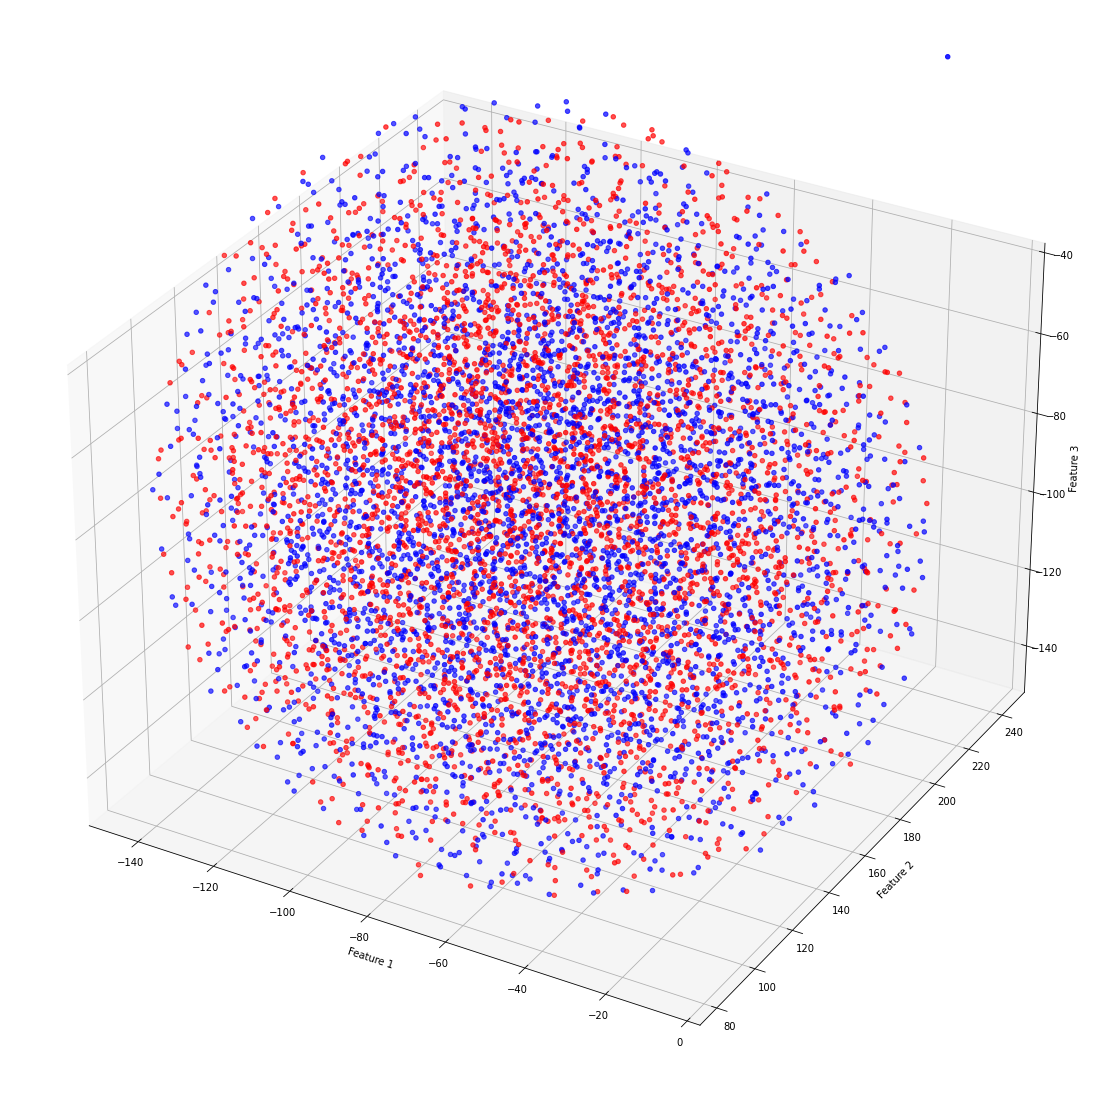

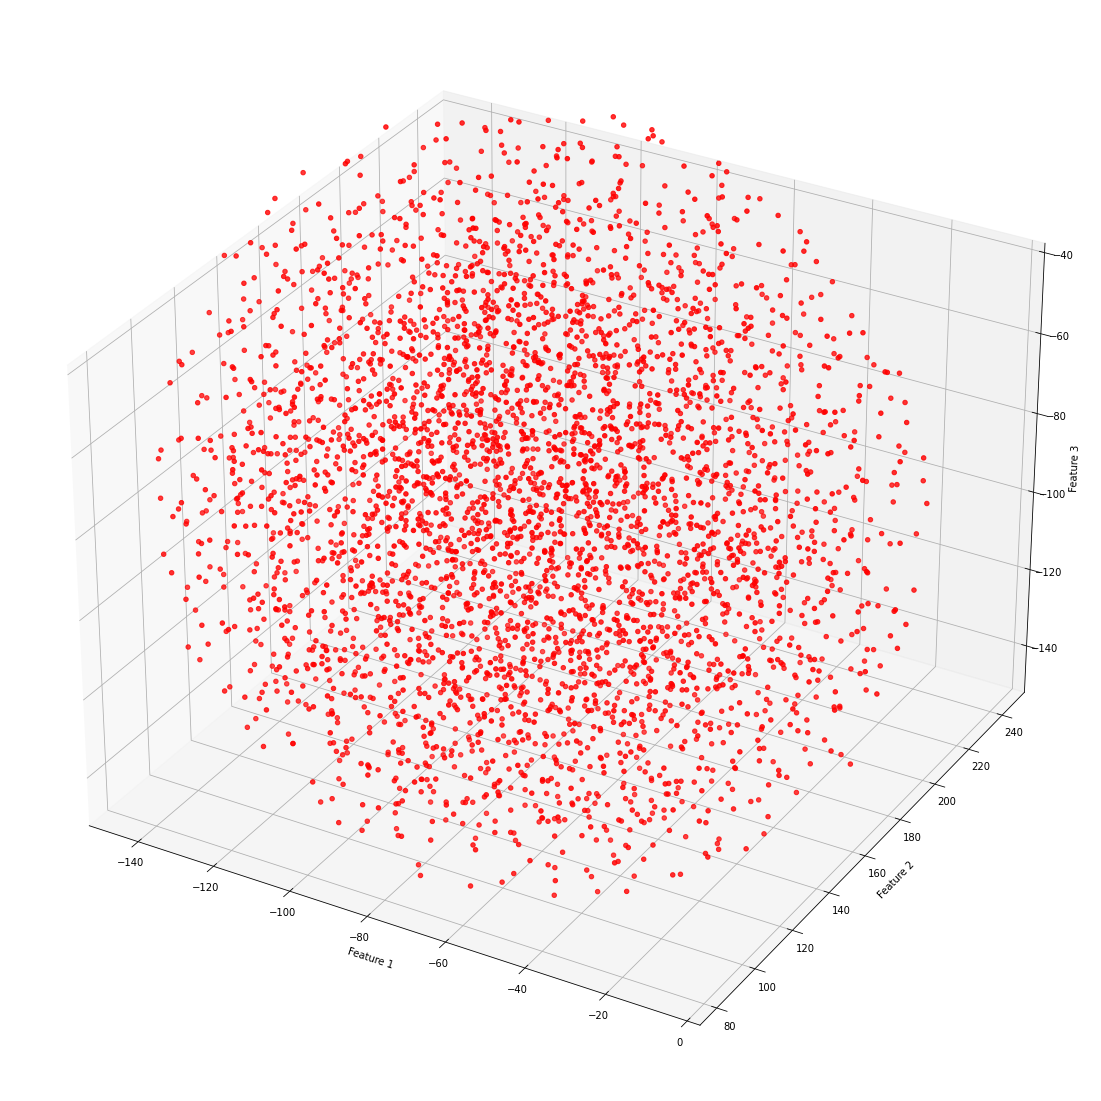

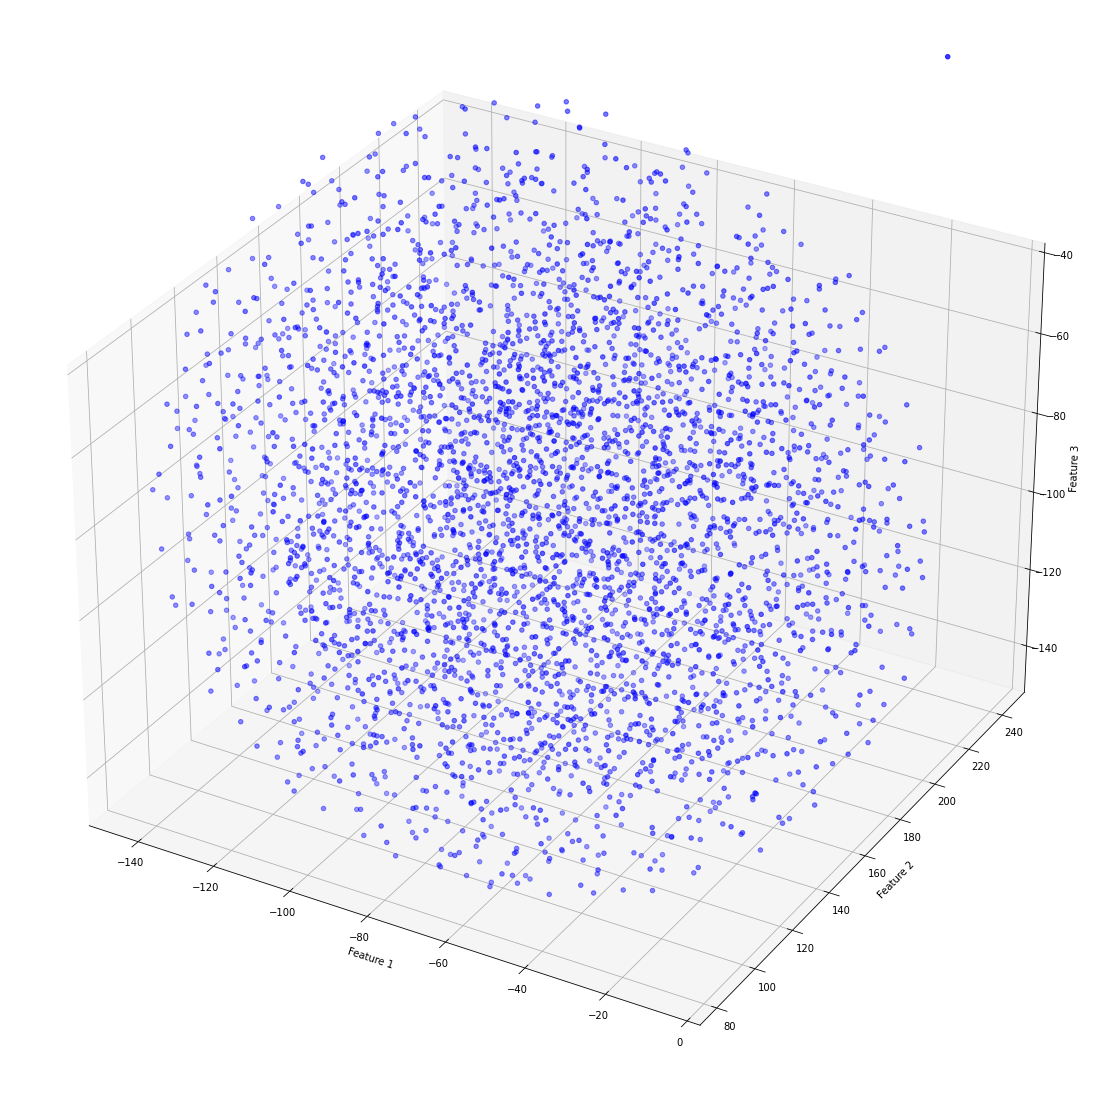

In [68]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdm3d100, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

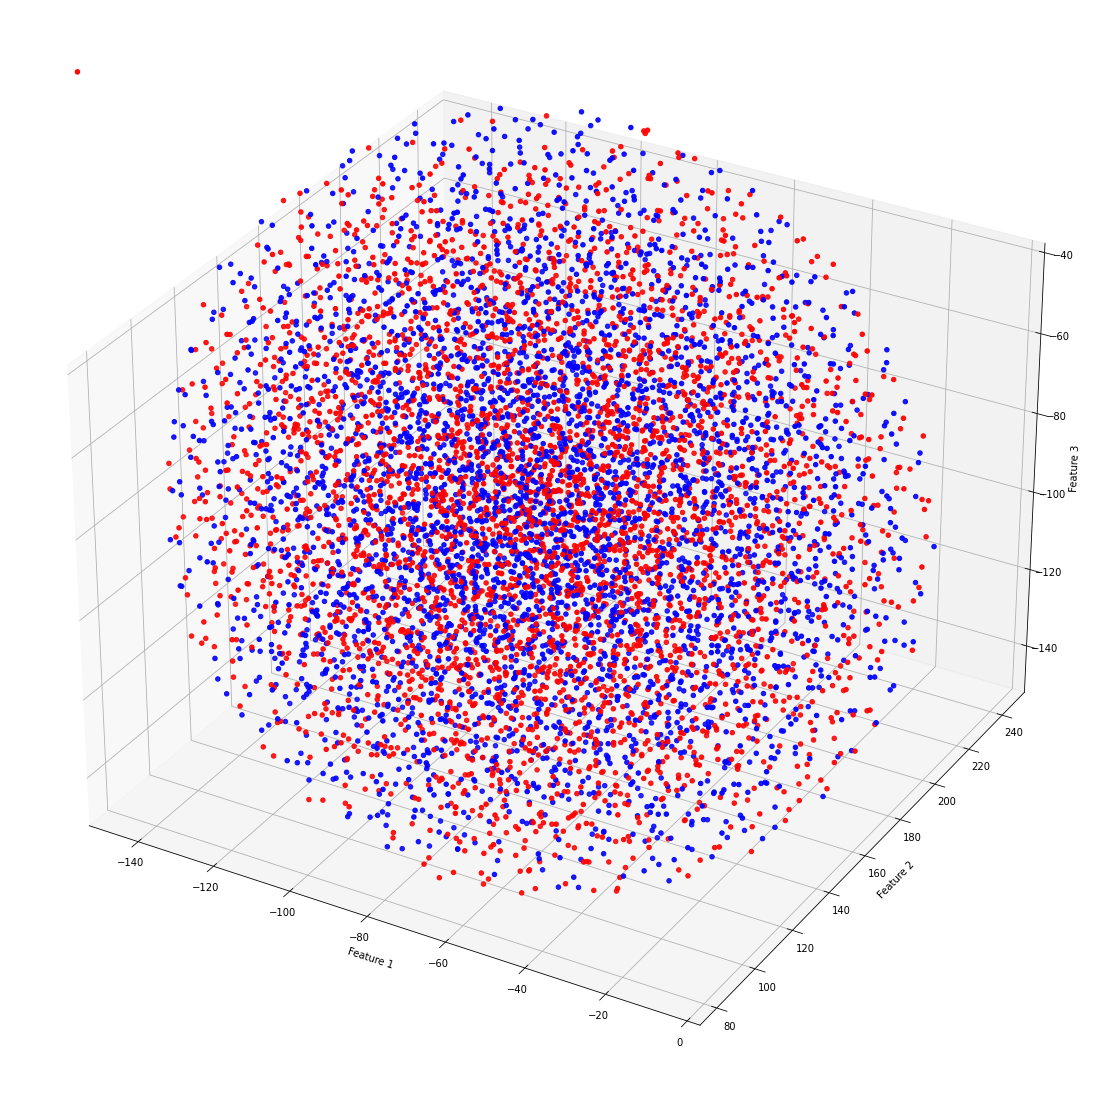

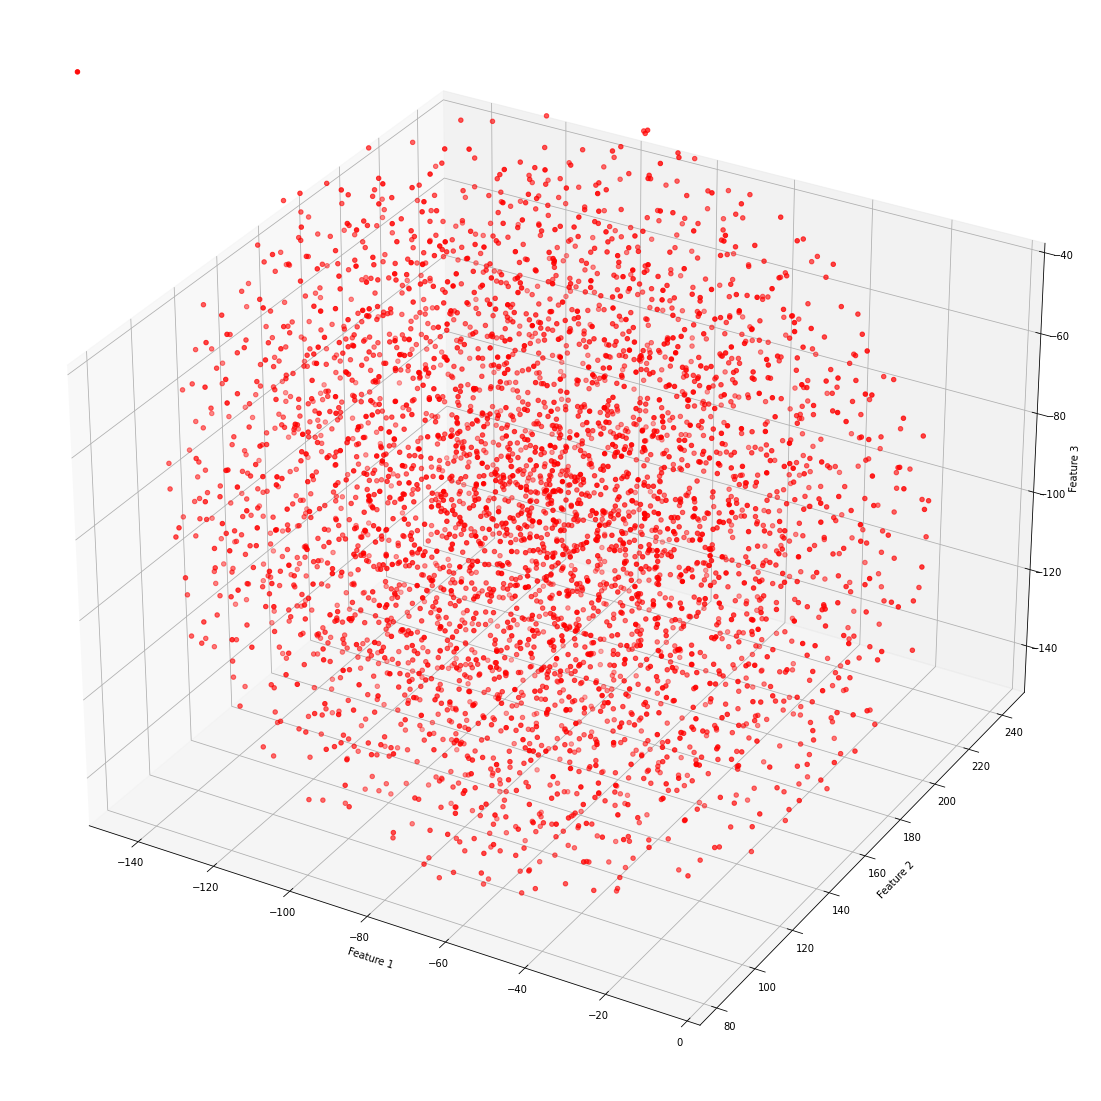

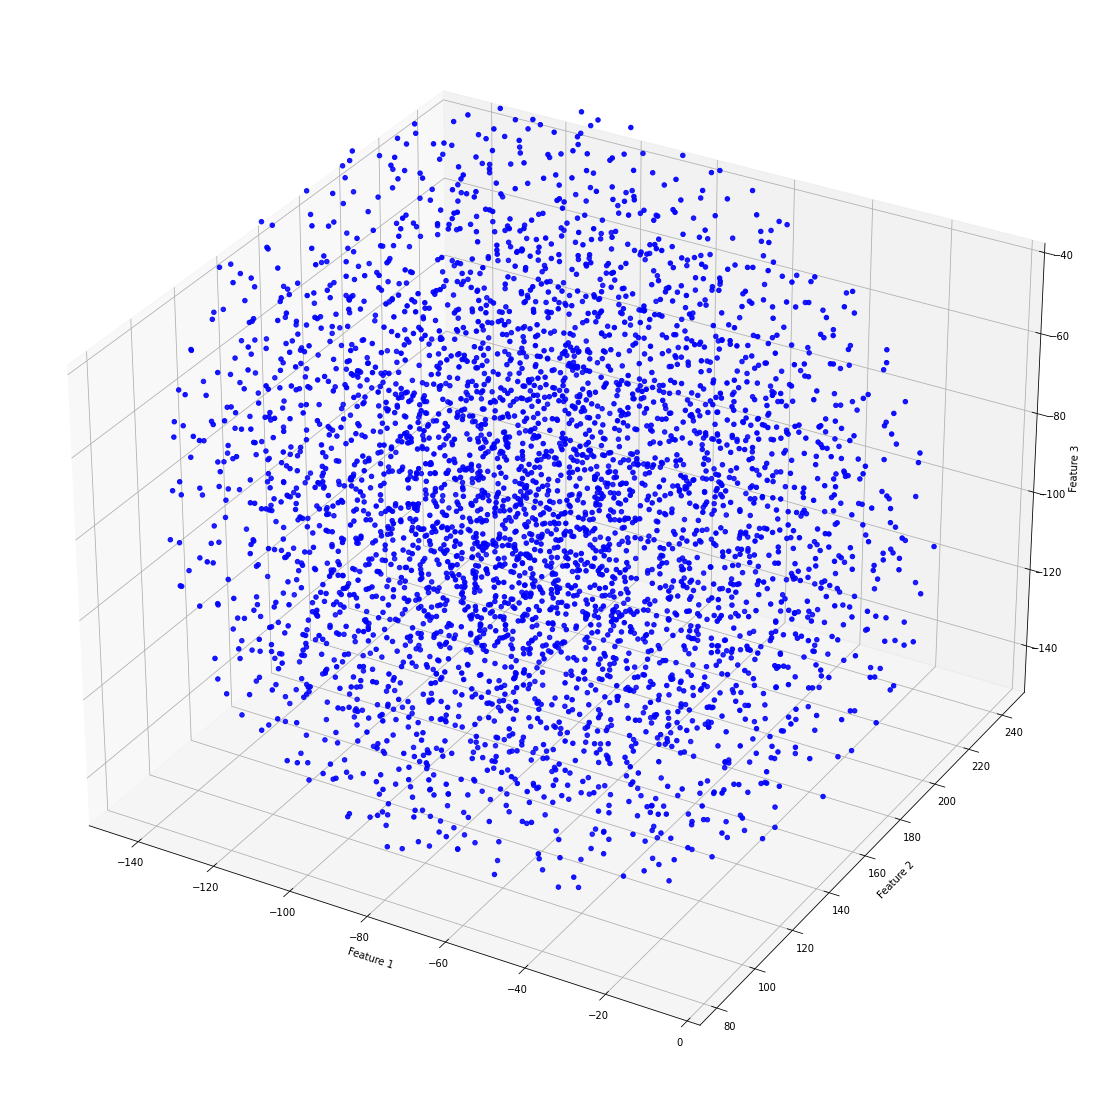

In [69]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdbow3d100, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

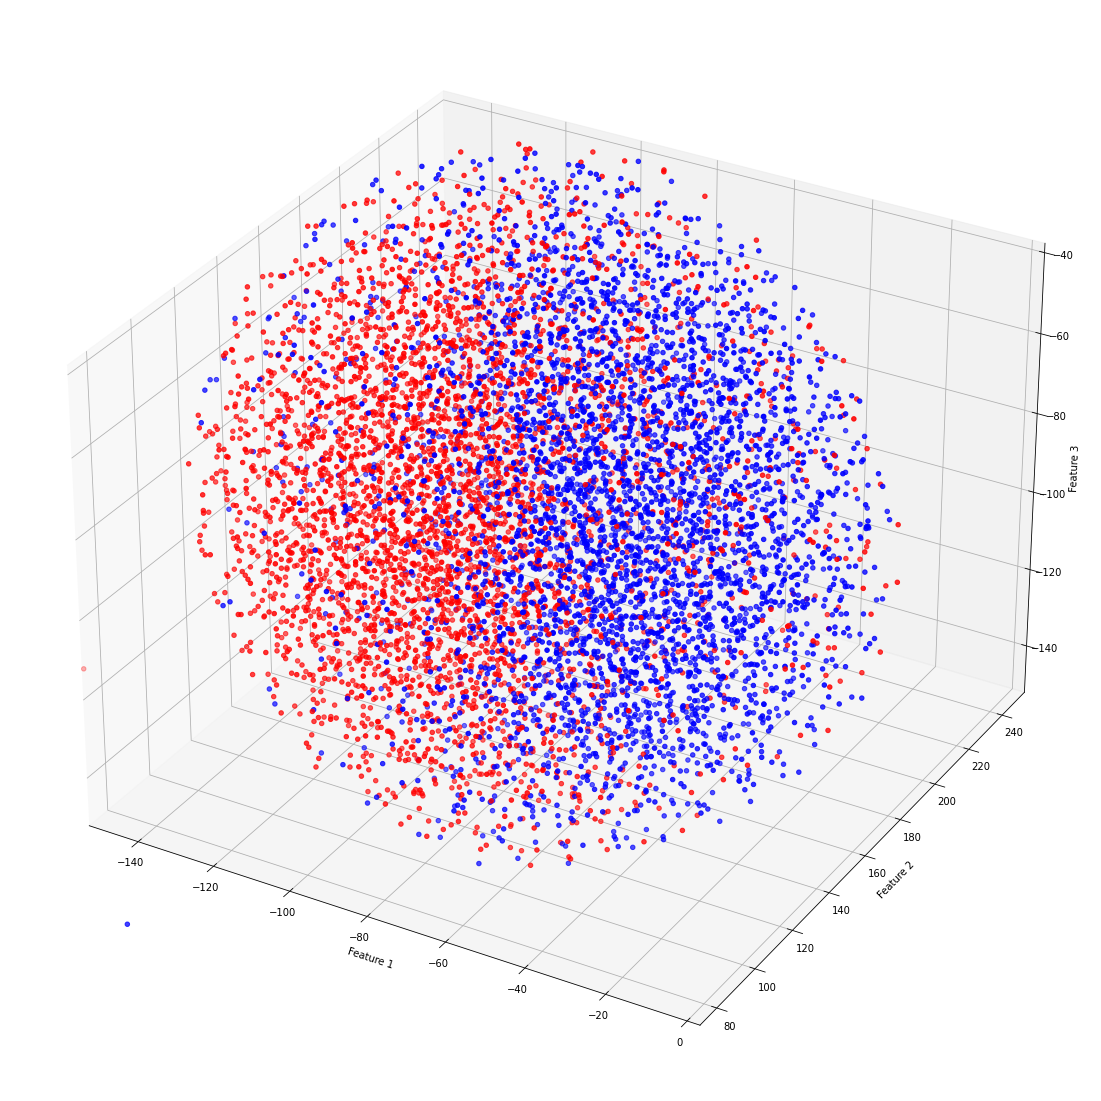

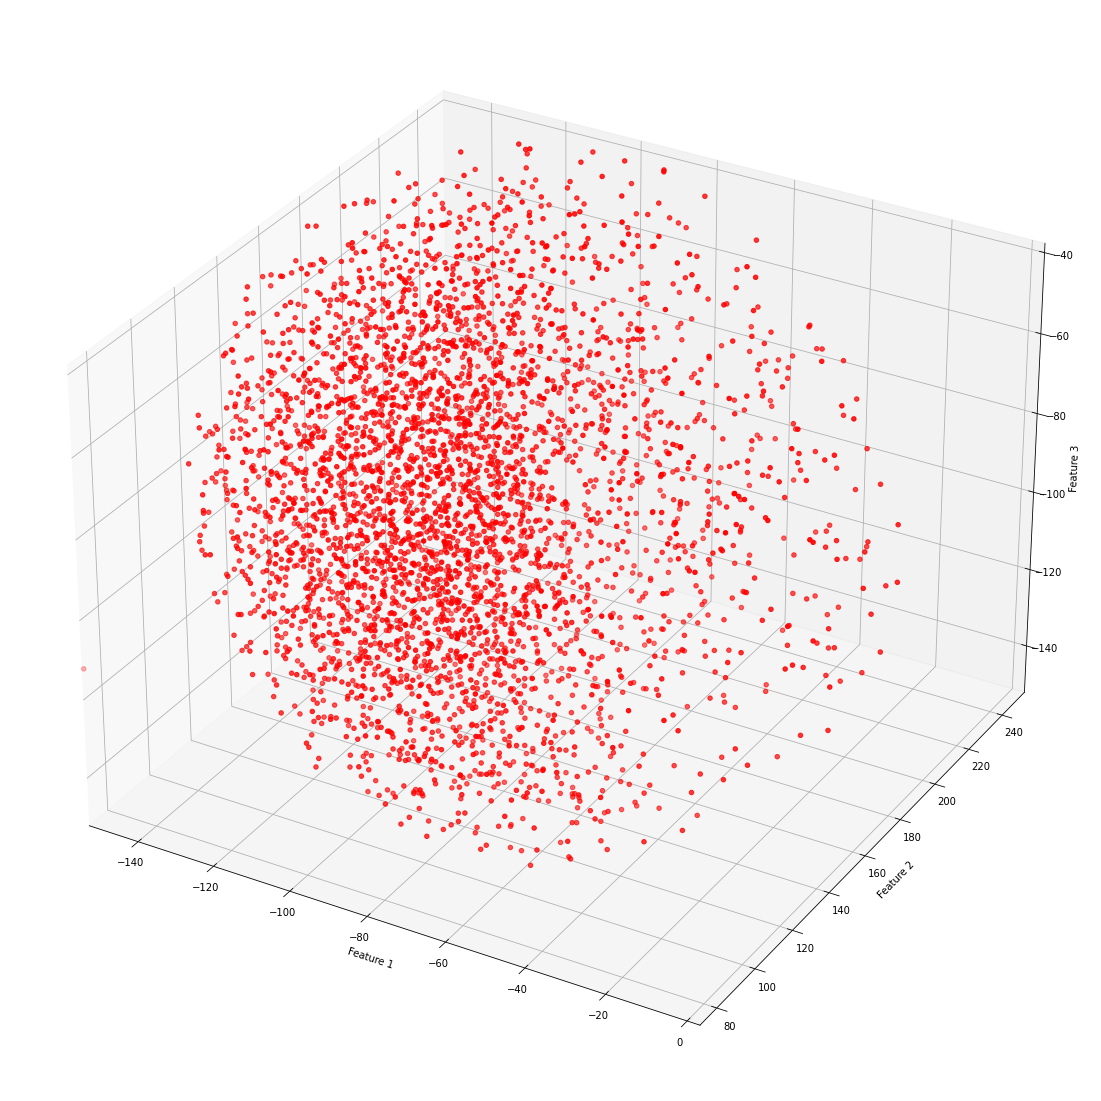

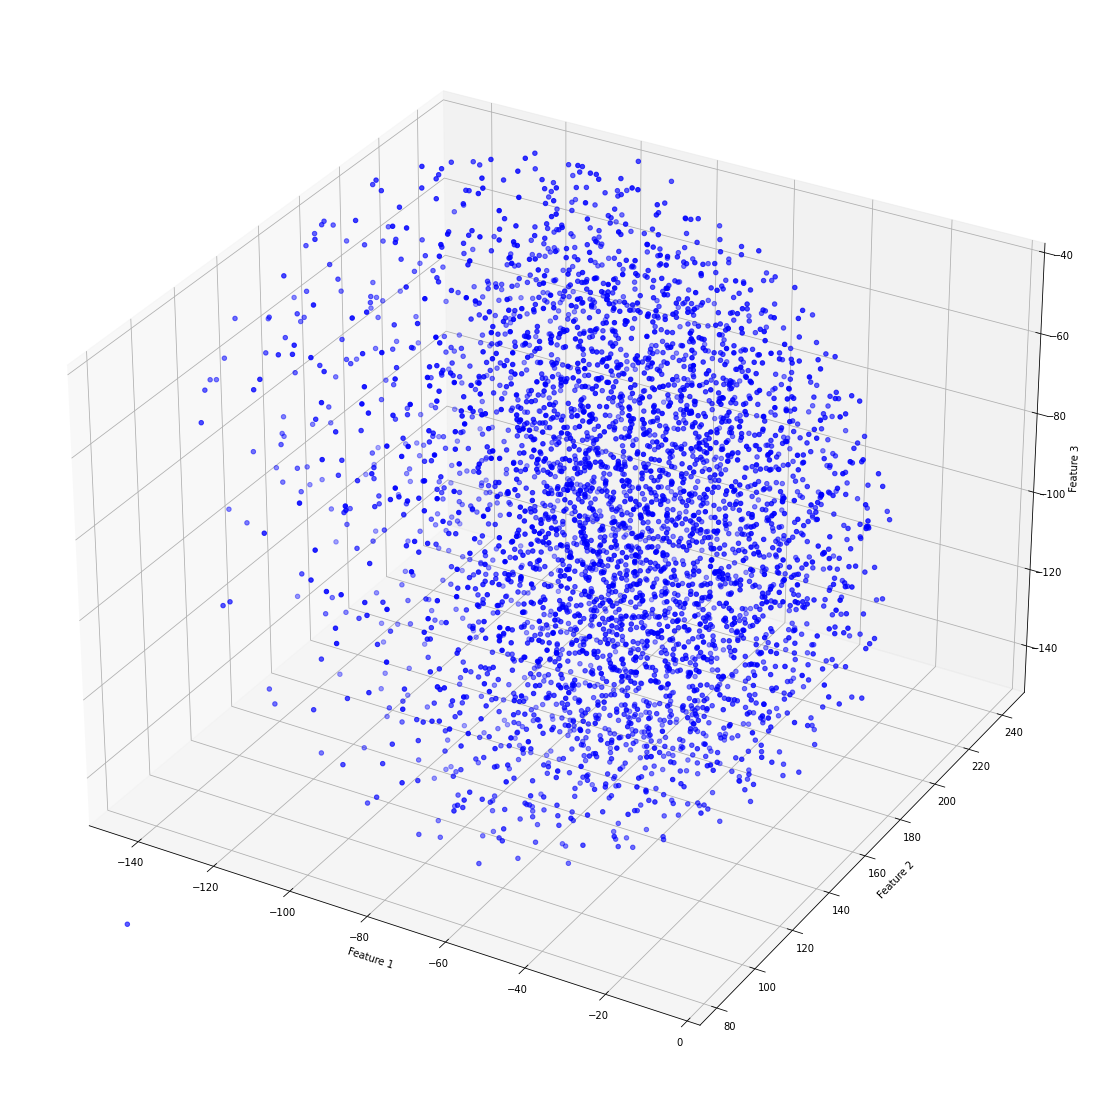

In [50]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdm3d, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

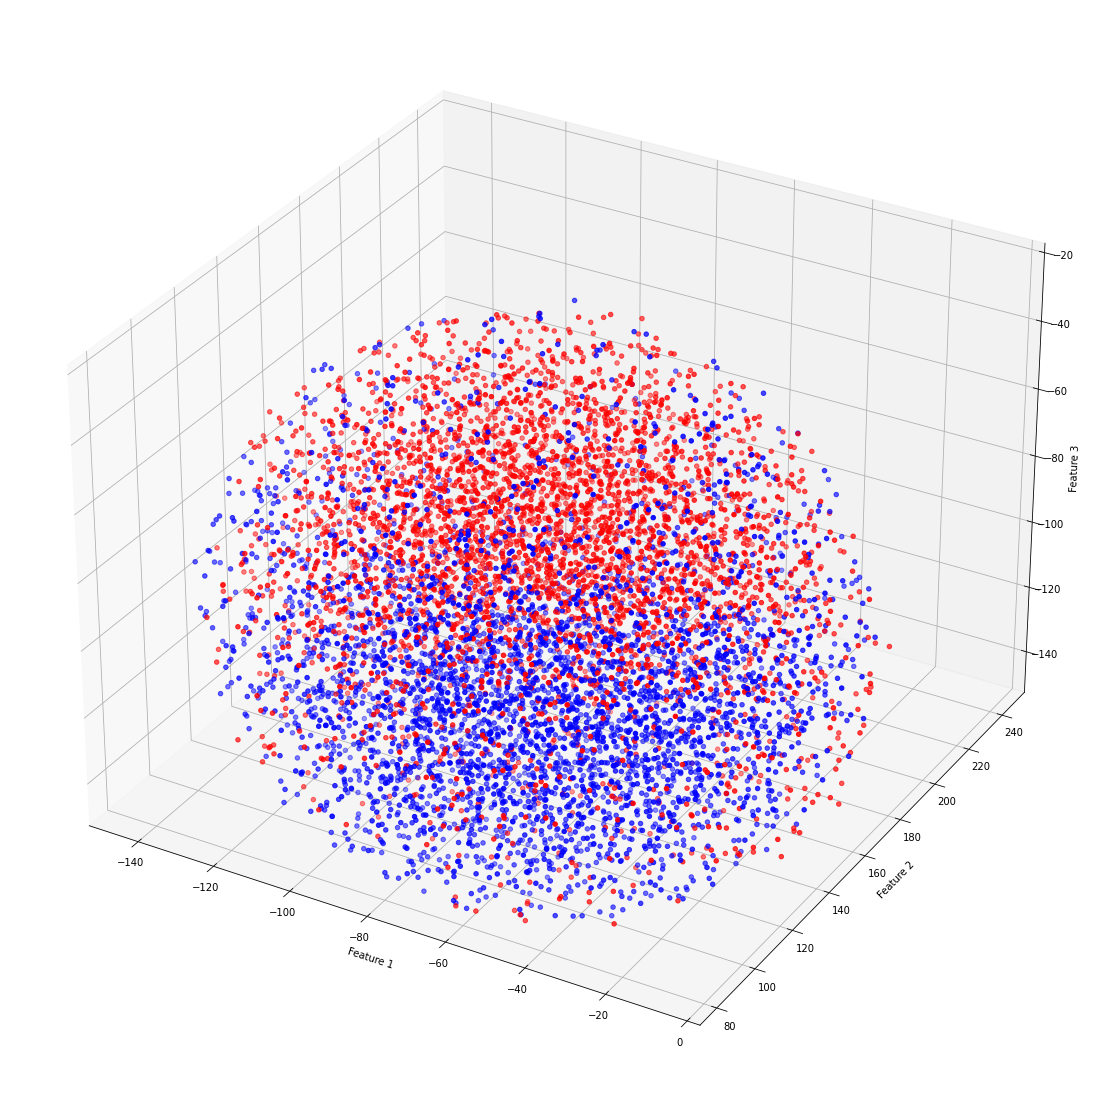

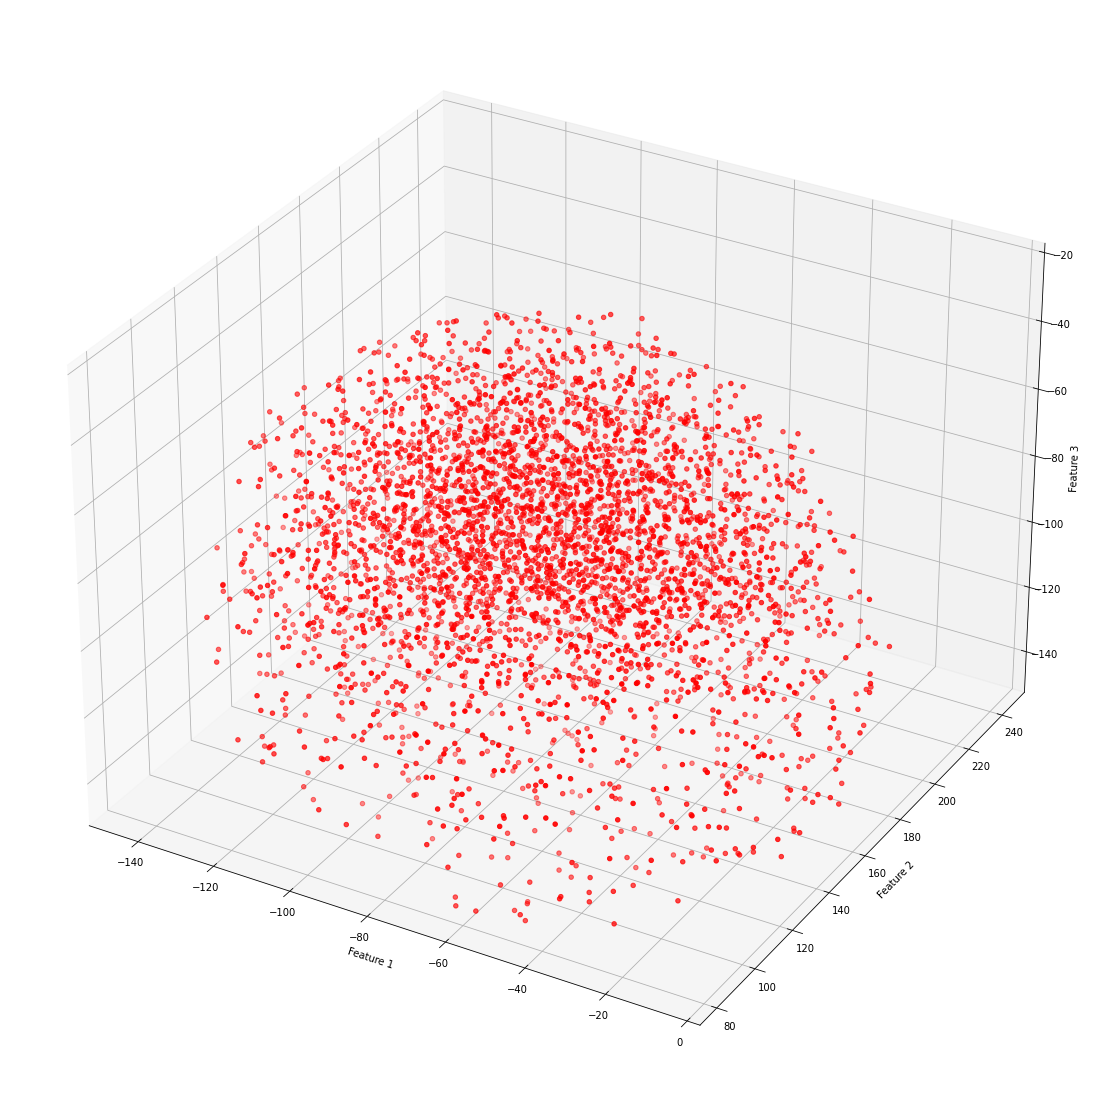

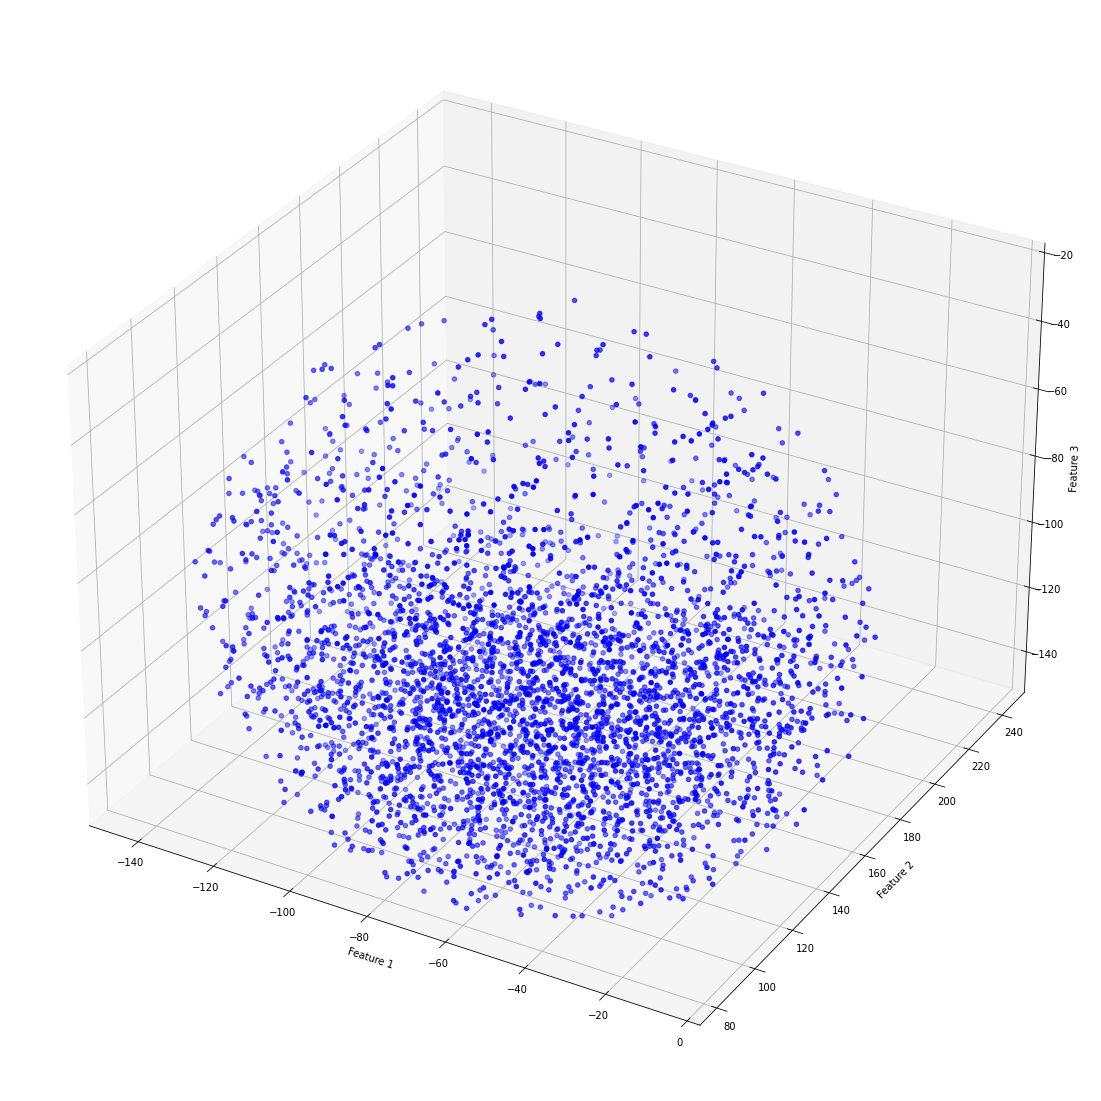

In [53]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdbow3d, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -20), size_3d=(20, 20))

# Logistic Regression + Bag of Words

In [216]:
def try_bow(**kwargs):
    cnt_vectorizer = CountVectorizer(stop_words=en_stop, **kwargs) # en_stop because the default has problems
    X_bow = cnt_vectorizer.fit_transform(df['Text'])
    X_train_bow, X_test_bow = split_bi(X_bow)

    # Scale data
    scaler_bow = StandardScaler(with_mean=False).fit(X_train_bow)
    X_train_bow_scaled = scaler_bow.transform(X_train_bow)
    X_test_bow_scaled = scaler_bow.transform(X_test_bow)
#     print(X_train_bow_scaled.shape, len(cnt_vectorizer.vocabulary_.keys()))
    
    lr_bow = LogisticRegression(max_iter=2000)
    lr_bow.fit(X_train_bow_scaled, y_train_bi)
    
    score_classifier(lr_bow, X_test_bow_scaled, big_table=False)

In [217]:
try_bow(min_df=5, ngram_range=(1, 1)) # Just unigrams

(8000, 14577) 14577
Mean accuracy: 0.505
TP: 522, FN: 495
FP: 495, TN: 488


In [218]:
try_bow(min_df=5, ngram_range=(1, 2)) # Unigrams and bigrams

(8000, 33867) 33867
Mean accuracy: 0.496
TP: 504, FN: 495
FP: 513, TN: 488


In [219]:
try_bow(min_df=5, ngram_range=(2, 2)) # Just bigrams

(8000, 19290) 19290
Mean accuracy: 0.4975
TP: 483, FN: 471
FP: 534, TN: 512


In [220]:
try_bow(min_df=5, ngram_range=(1, 3)) # Unigrams, bigrams, and trigrams

(8000, 34908) 34908
Mean accuracy: 0.4965
TP: 502, FN: 492
FP: 515, TN: 491


# Logistic Regression + TFIDF

In [207]:
def try_tfidf(X_train_tfidf, X_test_tfidf):    
    lr_tfidf = LogisticRegression()
    lr_tfidf.fit(X_train_tfidf, y_train_bi)
    
    score_classifier(lr_tfidf, X_test_tfidf)

In [208]:
X_train_tfidf_1, X_test_tfidf_1 = make_tfidf(ngram_range=(1, 1))
X_train_tfidf_1_2, X_test_tfidf_1_2 = make_tfidf(ngram_range=(1, 2))
X_train_tfidf_2, X_test_tfidf_2 = make_tfidf(ngram_range=(2, 2))

(8000, 14577) 14577
(8000, 33867) 33867
(8000, 19290) 19290


In [209]:
try_tfidf(X_train_tfidf_1, X_test_tfidf_1)

Mean accuracy: 0.4975
TP: 497, FN: 485
FP: 520, TN: 498
              precision    recall  f1-score   support

       False       0.49      0.51      0.50       982
        True       0.51      0.49      0.50      1018

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [210]:
try_tfidf(X_train_tfidf_1_2, X_test_tfidf_1_2)

Mean accuracy: 0.5025
TP: 504, FN: 482
FP: 513, TN: 501
              precision    recall  f1-score   support

       False       0.50      0.51      0.50       986
        True       0.51      0.49      0.50      1014

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [211]:
try_tfidf(X_train_tfidf_2, X_test_tfidf_2)

Mean accuracy: 0.499
TP: 477, FN: 462
FP: 540, TN: 521
              precision    recall  f1-score   support

       False       0.47      0.51      0.49       939
        True       0.53      0.49      0.51      1061

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [212]:
# Choose the best tf-idf model
X_train_tfidf = X_train_tfidf_1_2
X_test_tfidf = X_test_tfidf_1_2

# Logistic Regression + Doc2Vec (DM)

In [167]:
score_classifier(LogisticRegression().fit(X_train_d2vdm, y_train_bi), X_test_d2vdm)

Mean accuracy: 0.4995
TP: 567, FN: 551
FP: 450, TN: 432
              precision    recall  f1-score   support

       False       0.56      0.51      0.53      1118
        True       0.44      0.49      0.46       882

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.51      0.50      0.50      2000



# Logistic Regression + Doc2Vec (DBOW)

In [168]:
sum(y_train_bi == 1), len(y_train_bi)

(4017, 8000)

In [169]:
score_classifier(LogisticRegression().fit(X_train_d2vdbow, y_train_bi), X_test_d2vdbow)

Mean accuracy: 0.489
TP: 385, FN: 390
FP: 632, TN: 593
              precision    recall  f1-score   support

       False       0.38      0.50      0.43       775
        True       0.60      0.48      0.54      1225

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.52      0.49      0.50      2000



# Random forests + tf-idf

In [180]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifiers = [
    RandomForestClassifier(max_depth=5, random_state=1),
    RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1),
    RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1),
    RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1),
    RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1),
    RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2),
    RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2),
    RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2),
    RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1),
    RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1),
]

def try_random_forests(model_name):
    # TODO this is horrible
    X_train = eval('X_train_' + model_name)
    X_test = eval('X_test_' + model_name)
    for rfc in random_forest_classifiers:
        print(rfc)
        try_classifier(rfc, X_train, X_test, big_table=False)

In [181]:
try_random_forests('tfidf')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.4835
TP: 324, FN: 340
FP: 693, TN: 643
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.4785
TP: 309, FN: 335
FP: 708, TN: 648
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.476
TP: 301, FN: 332
FP: 716, TN: 651
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.4705
TP: 327, FN: 369
FP: 690, TN: 614
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.497
TP: 368, FN: 357
FP: 649, TN: 626
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.5145
TP: 470, FN: 424
FP: 547, TN: 559
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
           

# Random Forest + Doc2Vec (DM)

In [47]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=5, random_state=1))

Mean accuracy: 0.4905
TP: 486, FN: 488
FP: 531, TN: 495
              precision    recall  f1-score   support

       False       0.48      0.50      0.49       974
        True       0.50      0.48      0.49      1026

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [46]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1))

Mean accuracy: 0.497
TP: 510, FN: 499
FP: 507, TN: 484
              precision    recall  f1-score   support

       False       0.50      0.51      0.50      1009
        True       0.49      0.49      0.49       991

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [48]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.49
TP: 463, FN: 466
FP: 554, TN: 517
              precision    recall  f1-score   support

       False       0.46      0.50      0.48       929
        True       0.53      0.48      0.50      1071

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [49]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.493
TP: 455, FN: 452
FP: 562, TN: 531
              precision    recall  f1-score   support

       False       0.45      0.50      0.47       907
        True       0.54      0.49      0.51      1093

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.50      0.49      0.49      2000



In [50]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1))

Mean accuracy: 0.4945
TP: 469, FN: 463
FP: 548, TN: 520
              precision    recall  f1-score   support

       False       0.46      0.50      0.48       932
        True       0.53      0.49      0.51      1068

    accuracy                           0.49      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.50      0.49      0.50      2000



In [51]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2))

Mean accuracy: 0.4865
TP: 469, FN: 479
FP: 548, TN: 504
              precision    recall  f1-score   support

       False       0.46      0.49      0.48       948
        True       0.51      0.48      0.50      1052

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [52]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2))

Mean accuracy: 0.4965
TP: 460, FN: 450
FP: 557, TN: 533
              precision    recall  f1-score   support

       False       0.45      0.51      0.48       910
        True       0.54      0.49      0.51      1090

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [53]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2))

Mean accuracy: 0.487
TP: 465, FN: 474
FP: 552, TN: 509
              precision    recall  f1-score   support

       False       0.46      0.50      0.48       939
        True       0.52      0.48      0.50      1061

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [54]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1))

Mean accuracy: 0.4945
TP: 480, FN: 474
FP: 537, TN: 509
              precision    recall  f1-score   support

       False       0.47      0.50      0.49       954
        True       0.52      0.49      0.50      1046

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.50      0.49      0.49      2000



In [55]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.5
TP: 470, FN: 453
FP: 547, TN: 530
              precision    recall  f1-score   support

       False       0.46      0.51      0.48       923
        True       0.54      0.49      0.51      1077

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



# Random Forest + Doc2Vec (DBOW)

In [47]:
try_d2vdm_classifier(RandomForestClassifier(max_depth=5, random_state=1))

Mean accuracy: 0.4905
TP: 486, FN: 488
FP: 531, TN: 495
              precision    recall  f1-score   support

       False       0.48      0.50      0.49       974
        True       0.50      0.48      0.49      1026

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [60]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1))

Mean accuracy: 0.5085
TP: 442, FN: 408
FP: 575, TN: 575
              precision    recall  f1-score   support

       False       0.43      0.52      0.47       850
        True       0.58      0.50      0.54      1150

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.52      0.51      0.51      2000



In [61]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.4995
TP: 464, FN: 448
FP: 553, TN: 535
              precision    recall  f1-score   support

       False       0.46      0.51      0.48       912
        True       0.54      0.49      0.52      1088

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [62]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.4975
TP: 486, FN: 474
FP: 531, TN: 509
              precision    recall  f1-score   support

       False       0.48      0.51      0.49       960
        True       0.52      0.49      0.50      1040

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [63]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1))

Mean accuracy: 0.501
TP: 486, FN: 467
FP: 531, TN: 516
              precision    recall  f1-score   support

       False       0.48      0.51      0.49       953
        True       0.52      0.49      0.51      1047

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [64]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2))

Mean accuracy: 0.5085
TP: 511, FN: 477
FP: 506, TN: 506
              precision    recall  f1-score   support

       False       0.50      0.52      0.51       988
        True       0.51      0.50      0.51      1012

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [65]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2))

Mean accuracy: 0.5
TP: 486, FN: 469
FP: 531, TN: 514
              precision    recall  f1-score   support

       False       0.48      0.51      0.49       955
        True       0.52      0.49      0.51      1045

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [66]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2))

Mean accuracy: 0.4945
TP: 466, FN: 460
FP: 551, TN: 523
              precision    recall  f1-score   support

       False       0.46      0.50      0.48       926
        True       0.53      0.49      0.51      1074

    accuracy                           0.49      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.50      0.49      0.50      2000



In [67]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1))

Mean accuracy: 0.502
TP: 492, FN: 471
FP: 525, TN: 512
              precision    recall  f1-score   support

       False       0.48      0.51      0.50       963
        True       0.52      0.49      0.51      1037

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [68]:
try_d2vdbow_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.5045
TP: 496, FN: 470
FP: 521, TN: 513
              precision    recall  f1-score   support

       False       0.49      0.51      0.50       966
        True       0.52      0.50      0.51      1034

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.51      0.50      0.50      2000



# Random Forest + Doc2Vec (DM, 100 dims)

In [69]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=2, random_state=1))

Mean accuracy: 0.494
TP: 423, FN: 418
FP: 594, TN: 565
              precision    recall  f1-score   support

       False       0.42      0.50      0.46       841
        True       0.57      0.49      0.53      1159

    accuracy                           0.49      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.51      0.49      0.50      2000



In [70]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=3, random_state=1))

Mean accuracy: 0.4885
TP: 453, FN: 459
FP: 564, TN: 524
              precision    recall  f1-score   support

       False       0.45      0.50      0.47       912
        True       0.53      0.48      0.51      1088

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [71]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=5, random_state=1))

Mean accuracy: 0.491
TP: 492, FN: 493
FP: 525, TN: 490
              precision    recall  f1-score   support

       False       0.48      0.50      0.49       985
        True       0.50      0.48      0.49      1015

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [72]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1))

Mean accuracy: 0.492
TP: 495, FN: 494
FP: 522, TN: 489
              precision    recall  f1-score   support

       False       0.49      0.50      0.49       989
        True       0.50      0.48      0.49      1011

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [73]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.4985
TP: 464, FN: 450
FP: 553, TN: 533
              precision    recall  f1-score   support

       False       0.46      0.51      0.48       914
        True       0.54      0.49      0.52      1086

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [74]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.5015
TP: 486, FN: 466
FP: 531, TN: 517
              precision    recall  f1-score   support

       False       0.48      0.51      0.49       952
        True       0.53      0.49      0.51      1048

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [77]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1))

Mean accuracy: 0.488
TP: 453, FN: 460
FP: 564, TN: 523
              precision    recall  f1-score   support

       False       0.45      0.50      0.47       913
        True       0.53      0.48      0.51      1087

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [78]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2))

Mean accuracy: 0.513
TP: 497, FN: 454
FP: 520, TN: 529
              precision    recall  f1-score   support

       False       0.49      0.52      0.51       951
        True       0.54      0.50      0.52      1049

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [79]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2))

Mean accuracy: 0.492
TP: 467, FN: 466
FP: 550, TN: 517
              precision    recall  f1-score   support

       False       0.46      0.50      0.48       933
        True       0.53      0.48      0.50      1067

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [80]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2))

Mean accuracy: 0.509
TP: 511, FN: 476
FP: 506, TN: 507
              precision    recall  f1-score   support

       False       0.50      0.52      0.51       987
        True       0.52      0.50      0.51      1013

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [81]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1))

Mean accuracy: 0.5145
TP: 504, FN: 458
FP: 513, TN: 525
              precision    recall  f1-score   support

       False       0.50      0.52      0.51       962
        True       0.53      0.51      0.52      1038

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.52      0.51      0.51      2000



In [82]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.5175
TP: 500, FN: 448
FP: 517, TN: 535
              precision    recall  f1-score   support

       False       0.49      0.53      0.51       948
        True       0.54      0.51      0.53      1052

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



# Random Forest + Doc2Vec (DBOW, 100 dims)

In [83]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=2, random_state=1))

Mean accuracy: 0.511
TP: 394, FN: 355
FP: 623, TN: 628
              precision    recall  f1-score   support

       False       0.39      0.53      0.45       749
        True       0.64      0.50      0.56      1251

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.54      0.51      0.52      2000



In [84]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=3, random_state=1))

Mean accuracy: 0.511
TP: 421, FN: 382
FP: 596, TN: 601
              precision    recall  f1-score   support

       False       0.41      0.52      0.46       803
        True       0.61      0.50      0.55      1197

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.53      0.51      0.52      2000



In [85]:
try_d2vdm100_classifier(RandomForestClassifier(max_depth=5, random_state=1))

Mean accuracy: 0.491
TP: 492, FN: 493
FP: 525, TN: 490
              precision    recall  f1-score   support

       False       0.48      0.50      0.49       985
        True       0.50      0.48      0.49      1015

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [86]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1))

Mean accuracy: 0.5015
TP: 460, FN: 440
FP: 557, TN: 543
              precision    recall  f1-score   support

       False       0.45      0.51      0.48       900
        True       0.55      0.49      0.52      1100

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.51      0.50      0.50      2000



In [87]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.517
TP: 455, FN: 404
FP: 562, TN: 579
              precision    recall  f1-score   support

       False       0.45      0.53      0.49       859
        True       0.59      0.51      0.55      1141

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.53      0.52      0.52      2000



In [88]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.5145
TP: 468, FN: 422
FP: 549, TN: 561
              precision    recall  f1-score   support

       False       0.46      0.53      0.49       890
        True       0.57      0.51      0.54      1110

    accuracy                           0.51      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.51      0.52      2000



In [89]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1))

Mean accuracy: 0.5085
TP: 487, FN: 453
FP: 530, TN: 530
              precision    recall  f1-score   support

       False       0.48      0.52      0.50       940
        True       0.54      0.50      0.52      1060

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [90]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2))

Mean accuracy: 0.528
TP: 502, FN: 429
FP: 515, TN: 554
              precision    recall  f1-score   support

       False       0.49      0.54      0.52       931
        True       0.56      0.52      0.54      1069

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



In [91]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2))

Mean accuracy: 0.5255
TP: 507, FN: 439
FP: 510, TN: 544
              precision    recall  f1-score   support

       False       0.50      0.54      0.52       946
        True       0.55      0.52      0.53      1054

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



In [92]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2))

Mean accuracy: 0.52
TP: 524, FN: 467
FP: 493, TN: 516
              precision    recall  f1-score   support

       False       0.52      0.53      0.52       991
        True       0.52      0.51      0.52      1009

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [93]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1))

Mean accuracy: 0.517
TP: 492, FN: 441
FP: 525, TN: 542
              precision    recall  f1-score   support

       False       0.48      0.53      0.50       933
        True       0.55      0.51      0.53      1067

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [94]:
try_d2vdbow100_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.517
TP: 497, FN: 446
FP: 520, TN: 537
              precision    recall  f1-score   support

       False       0.49      0.53      0.51       943
        True       0.55      0.51      0.53      1057

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



# SVM + tf-idf

In [ ]:
try_tfidf_classifier(SVC(kernel='linear', random_state=1))

In [ ]:
try_tfidf_classifier(SVC(kernel='rbf', random_state=1))

In [ ]:
try_tfidf_classifier(SVC(kernel='poly', degree=2, random_state=1))

In [ ]:
try_tfidf_classifier(SVC(kernel='poly', degree=3, random_state=1))

In [ ]:
try_tfidf_classifier(SVC(kernel='sigmoid', random_state=1))

In [95]:
try_tfidf_classifier(SVC(kernel='linear', max_iter=1000, random_state=1))

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.508
TP: 537, FN: 504
FP: 480, TN: 479
              precision    recall  f1-score   support

       False       0.53      0.52      0.52      1041
        True       0.49      0.50      0.49       959

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [96]:
try_tfidf_classifier(SVC(kernel='rbf', max_iter=1000, random_state=1))

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.513
TP: 527, FN: 484
FP: 490, TN: 499
              precision    recall  f1-score   support

       False       0.52      0.52      0.52      1011
        True       0.51      0.50      0.51       989

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [97]:
try_tfidf_classifier(SVC(kernel='poly', degree=2, max_iter=1000, random_state=1))

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.4975
TP: 501, FN: 489
FP: 516, TN: 494
              precision    recall  f1-score   support

       False       0.49      0.51      0.50       990
        True       0.50      0.49      0.50      1010

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [98]:
try_tfidf_classifier(SVC(kernel='poly', degree=3, max_iter=1000, random_state=1))

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.4875
TP: 157, FN: 165
FP: 860, TN: 818
              precision    recall  f1-score   support

       False       0.15      0.49      0.23       322
        True       0.83      0.49      0.61      1678

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.42      2000
weighted avg       0.72      0.49      0.55      2000



In [99]:
try_tfidf_classifier(SVC(kernel='poly', degree=4, max_iter=1000, random_state=1))

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.4905
TP: 138, FN: 140
FP: 879, TN: 843
              precision    recall  f1-score   support

       False       0.14      0.50      0.21       278
        True       0.86      0.49      0.62      1722

    accuracy                           0.49      2000
   macro avg       0.50      0.49      0.42      2000
weighted avg       0.76      0.49      0.57      2000



In [100]:
try_tfidf_classifier(SVC(kernel='sigmoid', max_iter=1000, random_state=1))

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.5015
TP: 518, FN: 498
FP: 499, TN: 485
              precision    recall  f1-score   support

       False       0.51      0.51      0.51      1016
        True       0.49      0.49      0.49       984

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



# SVM + Doc2Vec (DM)

In [101]:
try_d2vdm_classifier(SVC(kernel='linear', max_iter=-1, random_state=1))

Mean accuracy: 0.502
TP: 580, FN: 559
FP: 437, TN: 424
              precision    recall  f1-score   support

       False       0.57      0.51      0.54      1139
        True       0.43      0.49      0.46       861

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.51      0.50      0.50      2000



In [102]:
try_d2vdm_classifier(SVC(kernel='rbf', max_iter=-1, random_state=1))

Mean accuracy: 0.4905
TP: 603, FN: 605
FP: 414, TN: 378
              precision    recall  f1-score   support

       False       0.59      0.50      0.54      1208
        True       0.38      0.48      0.43       792

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.51      0.49      0.50      2000



In [103]:
try_d2vdm_classifier(SVC(kernel='poly', degree=2, max_iter=-1, random_state=1))

Mean accuracy: 0.502
TP: 640, FN: 619
FP: 377, TN: 364
              precision    recall  f1-score   support

       False       0.63      0.51      0.56      1259
        True       0.37      0.49      0.42       741

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.53      0.50      0.51      2000



In [104]:
try_d2vdm_classifier(SVC(kernel='poly', degree=3, max_iter=-1, random_state=1))

Mean accuracy: 0.4885
TP: 620, FN: 626
FP: 397, TN: 357
              precision    recall  f1-score   support

       False       0.61      0.50      0.55      1246
        True       0.36      0.47      0.41       754

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.52      0.49      0.50      2000



In [105]:
try_d2vdm_classifier(SVC(kernel='poly', degree=4, max_iter=-1, random_state=1))

Mean accuracy: 0.4965
TP: 646, FN: 636
FP: 371, TN: 347
              precision    recall  f1-score   support

       False       0.64      0.50      0.56      1282
        True       0.35      0.48      0.41       718

    accuracy                           0.50      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.53      0.50      0.51      2000



In [106]:
try_d2vdm_classifier(SVC(kernel='sigmoid', max_iter=-1, random_state=1))

Mean accuracy: 0.492
TP: 525, FN: 524
FP: 492, TN: 459
              precision    recall  f1-score   support

       False       0.52      0.50      0.51      1049
        True       0.47      0.48      0.47       951

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



# SVM + Doc2Vec (DBOW)

In [107]:
try_d2vdbow_classifier(SVC(kernel='linear', max_iter=-1, random_state=1))

Mean accuracy: 0.4815
TP: 371, FN: 391
FP: 646, TN: 592
              precision    recall  f1-score   support

       False       0.36      0.49      0.42       762
        True       0.60      0.48      0.53      1238

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.51      0.48      0.49      2000



In [108]:
try_d2vdbow_classifier(SVC(kernel='rbf', max_iter=-1, random_state=1))

Mean accuracy: 0.5045
TP: 395, FN: 369
FP: 622, TN: 614
              precision    recall  f1-score   support

       False       0.39      0.52      0.44       764
        True       0.62      0.50      0.55      1236

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.53      0.50      0.51      2000



In [109]:
try_d2vdbow_classifier(SVC(kernel='poly', degree=2, max_iter=-1, random_state=1))

Mean accuracy: 0.5035
TP: 413, FN: 389
FP: 604, TN: 594
              precision    recall  f1-score   support

       False       0.41      0.51      0.45       802
        True       0.60      0.50      0.54      1198

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.52      0.50      0.51      2000



In [110]:
try_d2vdbow_classifier(SVC(kernel='poly', degree=3, max_iter=-1, random_state=1))

Mean accuracy: 0.5045
TP: 397, FN: 371
FP: 620, TN: 612
              precision    recall  f1-score   support

       False       0.39      0.52      0.44       768
        True       0.62      0.50      0.55      1232

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.53      0.50      0.51      2000



In [111]:
try_d2vdbow_classifier(SVC(kernel='poly', degree=4, max_iter=-1, random_state=1))

Mean accuracy: 0.499
TP: 395, FN: 380
FP: 622, TN: 603
              precision    recall  f1-score   support

       False       0.39      0.51      0.44       775
        True       0.61      0.49      0.55      1225

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.53      0.50      0.51      2000



In [112]:
try_d2vdbow_classifier(SVC(kernel='sigmoid', max_iter=-1, random_state=1))

Mean accuracy: 0.497
TP: 566, FN: 555
FP: 451, TN: 428
              precision    recall  f1-score   support

       False       0.56      0.50      0.53      1121
        True       0.44      0.49      0.46       879

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.50      0.50      0.50      2000



# Extra Trees + tf-idf

In [113]:
from sklearn.ensemble import ExtraTreesClassifier

In [114]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

Mean accuracy: 0.497
TP: 193, FN: 182
FP: 824, TN: 801
              precision    recall  f1-score   support

       False       0.19      0.51      0.28       375
        True       0.81      0.49      0.61      1625

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.45      2000
weighted avg       0.70      0.50      0.55      2000



In [115]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

Mean accuracy: 0.501
TP: 277, FN: 258
FP: 740, TN: 725
              precision    recall  f1-score   support

       False       0.27      0.52      0.36       535
        True       0.74      0.49      0.59      1465

    accuracy                           0.50      2000
   macro avg       0.50      0.51      0.47      2000
weighted avg       0.61      0.50      0.53      2000



In [116]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

Mean accuracy: 0.5065
TP: 341, FN: 311
FP: 676, TN: 672
              precision    recall  f1-score   support

       False       0.34      0.52      0.41       652
        True       0.68      0.50      0.58      1348

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.49      2000
weighted avg       0.57      0.51      0.52      2000



In [117]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

Mean accuracy: 0.496
TP: 177, FN: 168
FP: 840, TN: 815
              precision    recall  f1-score   support

       False       0.17      0.51      0.26       345
        True       0.83      0.49      0.62      1655

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.44      2000
weighted avg       0.72      0.50      0.56      2000



In [118]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

Mean accuracy: 0.4975
TP: 150, FN: 138
FP: 867, TN: 845
              precision    recall  f1-score   support

       False       0.15      0.52      0.23       288
        True       0.86      0.49      0.63      1712

    accuracy                           0.50      2000
   macro avg       0.50      0.51      0.43      2000
weighted avg       0.76      0.50      0.57      2000



In [119]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

Mean accuracy: 0.4945
TP: 266, FN: 260
FP: 751, TN: 723
              precision    recall  f1-score   support

       False       0.26      0.51      0.34       526
        True       0.74      0.49      0.59      1474

    accuracy                           0.49      2000
   macro avg       0.50      0.50      0.47      2000
weighted avg       0.61      0.49      0.52      2000



In [120]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

Mean accuracy: 0.511
TP: 324, FN: 285
FP: 693, TN: 698
              precision    recall  f1-score   support

       False       0.32      0.53      0.40       609
        True       0.71      0.50      0.59      1391

    accuracy                           0.51      2000
   macro avg       0.51      0.52      0.49      2000
weighted avg       0.59      0.51      0.53      2000



In [121]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

Mean accuracy: 0.502
TP: 316, FN: 295
FP: 701, TN: 688
              precision    recall  f1-score   support

       False       0.31      0.52      0.39       611
        True       0.70      0.50      0.58      1389

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.48      2000
weighted avg       0.58      0.50      0.52      2000



In [122]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.504
TP: 358, FN: 333
FP: 659, TN: 650
              precision    recall  f1-score   support

       False       0.35      0.52      0.42       691
        True       0.66      0.50      0.57      1309

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.49      2000
weighted avg       0.55      0.50      0.52      2000



In [123]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

Mean accuracy: 0.507
TP: 378, FN: 347
FP: 639, TN: 636
              precision    recall  f1-score   support

       False       0.37      0.52      0.43       725
        True       0.65      0.50      0.56      1275

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.55      0.51      0.52      2000



In [124]:
try_tfidf_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

Mean accuracy: 0.513
TP: 410, FN: 367
FP: 607, TN: 616
              precision    recall  f1-score   support

       False       0.40      0.53      0.46       777
        True       0.63      0.50      0.56      1223

    accuracy                           0.51      2000
   macro avg       0.51      0.52      0.51      2000
weighted avg       0.54      0.51      0.52      2000



# Extra Trees + Doc2Vec (DM)

In [125]:
from sklearn.ensemble import ExtraTreesClassifier

In [126]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

Mean accuracy: 0.496
TP: 438, FN: 429
FP: 579, TN: 554
              precision    recall  f1-score   support

       False       0.43      0.51      0.46       867
        True       0.56      0.49      0.52      1133

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.51      0.50      0.50      2000



In [127]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

Mean accuracy: 0.4865
TP: 527, FN: 537
FP: 490, TN: 446
              precision    recall  f1-score   support

       False       0.52      0.50      0.51      1064
        True       0.45      0.48      0.46       936

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [128]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

Mean accuracy: 0.5085
TP: 585, FN: 551
FP: 432, TN: 432
              precision    recall  f1-score   support

       False       0.58      0.51      0.54      1136
        True       0.44      0.50      0.47       864

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.52      0.51      0.51      2000



In [129]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

Mean accuracy: 0.4885
TP: 417, FN: 423
FP: 600, TN: 560
              precision    recall  f1-score   support

       False       0.41      0.50      0.45       840
        True       0.57      0.48      0.52      1160

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.50      0.49      0.49      2000



In [130]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

Mean accuracy: 0.49
TP: 408, FN: 411
FP: 609, TN: 572
              precision    recall  f1-score   support

       False       0.40      0.50      0.44       819
        True       0.58      0.48      0.53      1181

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.51      0.49      0.49      2000



In [131]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

Mean accuracy: 0.4805
TP: 515, FN: 537
FP: 502, TN: 446
              precision    recall  f1-score   support

       False       0.51      0.49      0.50      1052
        True       0.45      0.47      0.46       948

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000



In [132]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

Mean accuracy: 0.4855
TP: 545, FN: 557
FP: 472, TN: 426
              precision    recall  f1-score   support

       False       0.54      0.49      0.51      1102
        True       0.43      0.47      0.45       898

    accuracy                           0.49      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.49      0.49      0.49      2000



In [133]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

Mean accuracy: 0.4855
TP: 543, FN: 555
FP: 474, TN: 428
              precision    recall  f1-score   support

       False       0.53      0.49      0.51      1098
        True       0.44      0.47      0.45       902

    accuracy                           0.49      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.49      0.49      0.49      2000



In [134]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.495
TP: 572, FN: 565
FP: 445, TN: 418
              precision    recall  f1-score   support

       False       0.56      0.50      0.53      1137
        True       0.43      0.48      0.45       863

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.50      0.49      0.50      2000



In [135]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

Mean accuracy: 0.4895
TP: 549, FN: 553
FP: 468, TN: 430
              precision    recall  f1-score   support

       False       0.54      0.50      0.52      1102
        True       0.44      0.48      0.46       898

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [136]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

Mean accuracy: 0.4985
TP: 486, FN: 472
FP: 531, TN: 511
              precision    recall  f1-score   support

       False       0.48      0.51      0.49       958
        True       0.52      0.49      0.50      1042

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



# Extra Trees + Doc2Vec (DBOW)

In [137]:
from sklearn.ensemble import ExtraTreesClassifier

In [138]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

Mean accuracy: 0.4975
TP: 292, FN: 280
FP: 725, TN: 703
              precision    recall  f1-score   support

       False       0.29      0.51      0.37       572
        True       0.72      0.49      0.58      1428

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.48      2000
weighted avg       0.59      0.50      0.52      2000



In [139]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

Mean accuracy: 0.4905
TP: 360, FN: 362
FP: 657, TN: 621
              precision    recall  f1-score   support

       False       0.35      0.50      0.41       722
        True       0.63      0.49      0.55      1278

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.53      0.49      0.50      2000



In [140]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

Mean accuracy: 0.4985
TP: 388, FN: 374
FP: 629, TN: 609
              precision    recall  f1-score   support

       False       0.38      0.51      0.44       762
        True       0.62      0.49      0.55      1238

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.53      0.50      0.51      2000



In [141]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

Mean accuracy: 0.5025
TP: 293, FN: 271
FP: 724, TN: 712
              precision    recall  f1-score   support

       False       0.29      0.52      0.37       564
        True       0.72      0.50      0.59      1436

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.48      2000
weighted avg       0.60      0.50      0.53      2000



In [142]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

Mean accuracy: 0.498
TP: 288, FN: 275
FP: 729, TN: 708
              precision    recall  f1-score   support

       False       0.28      0.51      0.36       563
        True       0.72      0.49      0.59      1437

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.47      2000
weighted avg       0.60      0.50      0.52      2000



In [143]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

Mean accuracy: 0.489
TP: 351, FN: 356
FP: 666, TN: 627
              precision    recall  f1-score   support

       False       0.35      0.50      0.41       707
        True       0.64      0.48      0.55      1293

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.53      0.49      0.50      2000



In [144]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

Mean accuracy: 0.496
TP: 419, FN: 410
FP: 598, TN: 573
              precision    recall  f1-score   support

       False       0.41      0.51      0.45       829
        True       0.58      0.49      0.53      1171

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.51      0.50      0.50      2000



In [145]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

Mean accuracy: 0.4985
TP: 400, FN: 386
FP: 617, TN: 597
              precision    recall  f1-score   support

       False       0.39      0.51      0.44       786
        True       0.61      0.49      0.54      1214

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.52      0.50      0.50      2000



In [146]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.4915
TP: 479, FN: 479
FP: 538, TN: 504
              precision    recall  f1-score   support

       False       0.47      0.50      0.49       958
        True       0.51      0.48      0.50      1042

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [147]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

Mean accuracy: 0.5055
TP: 491, FN: 463
FP: 526, TN: 520
              precision    recall  f1-score   support

       False       0.48      0.51      0.50       954
        True       0.53      0.50      0.51      1046

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [148]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

Mean accuracy: 0.5025
TP: 497, FN: 475
FP: 520, TN: 508
              precision    recall  f1-score   support

       False       0.49      0.51      0.50       972
        True       0.52      0.49      0.51      1028

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



# Extra Trees + Doc2Vec (DM, 100 dims)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

In [ ]:
try_d2vdm100_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

# Extra Trees + Doc2Vec (DBOW, 100 dims)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

In [ ]:
try_d2vdbow100_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

{'LogisticRegression()': (0.489,
  array([[385, 390],
         [632, 593]], dtype=int64)),
 'RandomForestClassifier(max_depth=2, random_state=1)': (0.511,
  array([[394, 355],
         [623, 628]], dtype=int64)),
 'RandomForestClassifier(max_depth=3, random_state=1)': (0.511,
  array([[421, 382],
         [596, 601]], dtype=int64)),
 'RandomForestClassifier(max_depth=5, random_state=1)': (0.491,
  array([[492, 493],
         [525, 490]], dtype=int64)),
 'RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)': (0.5015,
  array([[460, 440],
         [557, 543]], dtype=int64)),
 'RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,\n                       random_state=1)': (0.517,
  array([[455, 404],
         [562, 579]], dtype=int64)),
 'RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,\n                       random_state=1)': (0.5145,
  array([[468, 422],
         [549, 561]], dtype=int64)),
 'RandomForestClassifier(max_de

In [ ]:
classifier_results